# Example Filtering ICON Data on Native Grid
_Aaron Wienkers, 2025_

## *"Easy"* Installation of `implicit_filter_ICON` on DKRZ-Levante:

```bash
# Make new Conda Env
conda create -n ICON_filter python=3.10 -c conda-forge
conda activate ICON_filter

# Install Dependencies
conda install jupyterlab mpi4py xarray[complete] dask[complete]=2025.3.0 dask-image dask-jobqueue dask-mpi intake intake-esm  intake-xarray aiohttp fastparquet cartopy cython statsmodels jax jaxlib cf-units cfgrib eccodes python-eccodes

pip install pyicon-diagnostics

# Build AMGX (NVIDIA AMG Solvers), or just use the one I've build on Levante
#  (cf. https://github.com/NVIDIA/AMGX)
#  then install pyAMGX wrapper
export AMGX_DIR=/home/b/b382615/opt/AMGX
BUILD_DIR=~/ICON_filter
mkdir -p ${BUILD_DIR} && cd "$_"
git clone https://git@github.com/wienkers/pyamgx.git
pip install ./pyamgx

# Install CuPy (N.B.: Needs to be done on a GPU node!)
e.g.,  srun -A ${PROJ}  -p gpu  --cpus-per-task 4 --wait 0 --gpus=a100_80:1  --time 0:09:00 --pty /bin/bash
conda activate ICON_filter  # in case it deactivated

# Finally, install `implicit_filter_ICON` !
git clone https://github.com/wienkers/implicit_filter_ICON.git
pip install ./implicit_filter_ICON

```
### _Advanced_ Installation:
- Load Intel-compiled `cuda` and build your dependencies with Intel compilers for ~50% faster filtering.
- The `AMGX` build I've provided is built on Intel 2021.5.0, the above instructions for `cupy` & `jax` are not optimised. 

## Getting-Started with `implicit_filter_ICON` on DKRZ-Levante:
- You will need to run on a GPU node, e.g. `srun -A ${PROJ} -p gpu  --cpus-per-task 128 --wait 0 --gpus=a100_80:4  --time 0:29:00 --pty /bin/bash`
- If using a 1st Order filter, then the `a100_40` (i.e. 40Gb) GPUs are sufficient; however, the 2nd Order filter requires the `a100_80` GPUs.
- If you're just filtering a few time slices, then you can use the `--gpus=a100_80:1` option to use only 1 GPU.
- Notes for filtering large datasets:
    - The filtering routine is MPI-parallelised to utilse all 4 GPUs on the Levante GPU node, if available.
    - `dask` is a bit ignorant of what the GPUs are up to, so you may need to batch calls to `filter.filter_ICON()` to keep within the node memory. 
    - On the Levante GPU nodes, and using the EERIE-ICON output (R2B9 ~5km), then a batch-size of 40 time-slices works well. It is advantageous to have as large a batch-size as possible, to reduce the high overhead of communicating with the GPUs. 
- Don't worry about a warning like `An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.` The AMGX linear solver is still using the GPU.

### Modifications from main branch of `implicit_filter`:
1. Built-in support for the `ICON` grid
    - Uses new JAX routines for vertex- and cell-centred transformations
2. Support for spatially-varying length-scale filters, e.g. if $\Delta \propto \mathcal{L}_\mathrm{Ro}$
3. Implements arbitrary boundary conditions in a conservative fashion
    - This is necessary when filtering deeper layers in the ocean when the sea-floor boundaries change
    - These BCs ensure no artificial mass/energy/tracer leakage through the boundaries, and which otherwise produces halos in the high-pass fields
4. Adds MPI support for multi-GPU machines
    - Batches GPU computations (in time & wavenumber space) to avoid running out of memory
5. Improves convergence properties of 2nd Order filter using a tuned Algebriac Multigrid Solver (AMGX)
    - CG Convergence of the 2nd Order filter with the original block-wise structure was either slow or (for larger filter length-scales $\sim 100$ km) divergent
    - AMGX Solver Converges faster on 2nd Order Filter compared to `cupy` CG implementation of 1st Order Filter, even up to $\Delta \approx 10^4$ km
    - N.B.: Using 2nd Order filter is necessary for many higher-order filtered statistics and when a sharp(er) filter cutoff is required


In [1]:
import xarray as xr

import intake
import dask
import subprocess
import pyicon as pyic
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm

from dask.distributed import Client, LocalCluster

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
import os
import re
import warnings

try:
    from implicit_filter import AMGXFilter, CuPyFilter
except ImportError:
    warnings.warn("GPU Needed to run this notebook with AMGX Filter")


----Start loading pyicon.
----Start loading pyicon.
----Pyicon was loaded successfully.
----Pyicon was loaded successfully.


# Setup

In [2]:
remake_filter = False # Should we re-compute (and over-write) the filter ?   (N.B.: This takes ~8 minutes per filter)


## Directories
scratch_dir          = Path('/scratch') / getuser()[0] / getuser()
filter_dir           = scratch_dir / 'filters'
zarr_fpath_tgrid     = scratch_dir / 'grid_files'  / 'fpath_tgrid.zarr'  # For faster unstructured plotting
cluster_scratch      = scratch_dir / 'clients'

## Start Local GPU Cluster

In [3]:
dask_tmp_dir = TemporaryDirectory(dir=cluster_scratch)
dask.config.set(temporary_directory=dask_tmp_dir.name)
dask.config.set({'array.slicing.split_large_chunks': False})

cluster = LocalCluster(n_workers=8, threads_per_worker=4, memory_limit="60GiB")
client = Client(cluster)
#client

remote_node = subprocess.run(['hostname'], capture_output=True, text=True).stdout.strip().split('.')[0]
port = re.search(r':(\d+)/', client.dashboard_link).group(1)
print(f"Forward with Port = {remote_node}:{port}")

client.dashboard_link

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37651 instead
  warnings.warn(


Forward with Port = l50045:37651


'http://127.0.0.1:37651/status'

## Open & Prepare Data

In [4]:
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
expid = 'eerie-control-1950'
version = 'v20240618'
model = 'icon-esm-er'
gridspec = 'native'

In [5]:
## Ocean EERIE Catalogue
dat = cat['dkrz.disk.model-output'][model][expid][version]['ocean'][gridspec]
ds_ocn = dat['2d_daily_mean'](chunks={}).to_dask()

# N.B. on Dask Data:
#  - We need to drop all singleton coordinates/dimensions
#  - We need to ensure that the spatial dimension is in a single chunk
ds_ocn = (ds_ocn.isel(depth=0).isel(lev=0).drop_vars({'depth','lev'})
                 .chunk({'ncells': -1}))

In [6]:
## ICON Grid Properties
grid2d = dat['2d_grid'](chunks={}).to_dask().rename({'cell':'ncells'})
depth_ind = 0

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/intake/readers/readers.py:1327: UserWarning: The specified chunks separate the stored chunks along dimension "nc" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  return open_dataset(data.url, **kw)
/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/intake/readers/readers.py:1327: UserWarning: The specified chunks separate the stored chunks along dimension "edge" starting at index 16777214. This could degrade performance. Instead, consider rechunking after loading.
  return open_dataset(data.url, **kw)
/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/intake/readers/readers.py:1327: UserWarning: The specified chunks separate the stored chunks along dimension "cell" starting at index 8388606. This could degrade performance. Instead, consider rechunking after loading.
  return open_dataset(data.url, **kw)
/home/b/

## Compute / Load Grid Data

In [7]:
if not os.path.exists(str(zarr_fpath_tgrid)):
    from pyicon.pyicon_tb import identify_grid
    from pyicon.pyicon_params import params
    path_grid = params['path_grid']
    Dgrid = identify_grid(grid2d, path_grid, uuidOfHGrid=grid2d.attrs['uuidOfHGrid'])
    fpath_tgrid = Dgrid['fpath_grid']
    ds_tg = xr.open_dataset(fpath_tgrid, chunks={})
    ds_tg.to_zarr(zarr_fpath_tgrid, mode='w')
    

# Example 1: Constant Length-Scale Filter

### Compute / Load & Define Filter

Construct a filter here defined by:
- Constant length-scale, $\Delta = 300 \mathrm{km}$
- Neumann BCs at edge of surface land-sea mask
- Both scalar & full vector-metric filters

In [8]:
filter_lengthscale = 300 #km
filter_order = 1

In [ ]:
# Make Constant Filter (takes ~8 minutes per filter)
if remake_filter or not os.path.exists(str(filter_dir / "filter_cache_2D_const_full_ocean.npz")):
    mask = grid2d.cell_sea_land_mask
    full_ocean_mask = xr.where(mask < 0.0, 1.0, 0.0)  # 1.0 for entire ocean  
    
    # Filter for Scalar Fields
    filter_uniform = AMGXFilter()
    filter_uniform.prepare_ICON_filter(grid2d, ocean_mask=full_ocean_mask, full=False)
    filter_uniform.save_to_file(filter_dir / "filter_cache_2D_const_full_ocean")
    
    # Filter for Vector Fields ("full" = True)
    filter_vec_uniform = AMGXFilter()
    filter_vec_uniform.prepare_ICON_filter(grid2d, ocean_mask=full_ocean_mask, full=True)
    filter_vec_uniform.save_to_file(filter_dir / "filter_cache_full_2D_const_full_ocean")

else:
    filter_uniform = AMGXFilter.load_from_file(filter_dir / "filter_cache_2D_const_full_ocean.npz")
    filter_vec_uniform = AMGXFilter.load_from_file(filter_dir / "filter_cache_full_2D_const_full_ocean.npz")

### Filter Scalar Data
Note: 60 time-slices takes ~90 seconds (*70 seconds of which is overhead / GPU IO!*)

In [ ]:
t_slice = slice('2024-01-01', '2024-03-01')

## Low-pass filter
sst_full = ds_ocn.to.sel(time=t_slice)
sst_low = filter_uniform.filter_ICON(filter_order, filter_lengthscale, sst_full)

## High-pass filter
sst_high = (sst_full - sst_low)

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 3.38 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'left': 'High-pass SST', 'right': '2024-03-01T23:59:59'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff3181109a0>])

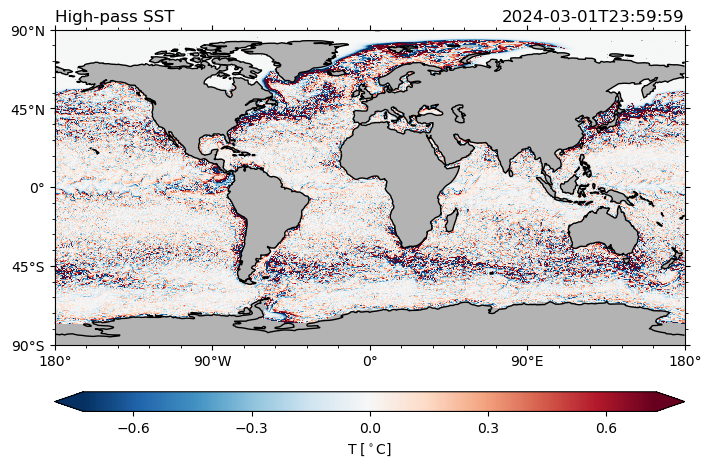

In [11]:
sst_high.isel(time=-1).pyic.plot(clim='robustsym', title_left="High-pass SST", cbar_str=f"T [$^\circ$C]", fpath_tgrid=zarr_fpath_tgrid)

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 3.38 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'left': 'Low-pass SST', 'right': '2024-03-01T23:59:59'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff2dc380040>])

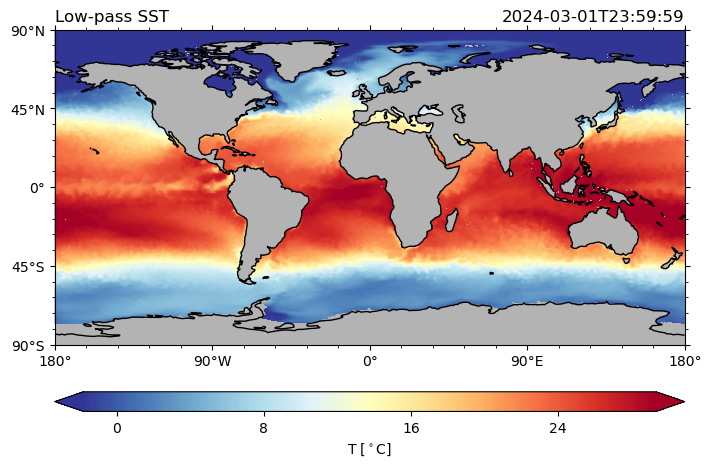

In [12]:
sst_low.isel(time=-1).pyic.plot(clim='robust', title_left="Low-pass SST", cbar_str=f"T [$^\circ$C]", fpath_tgrid=zarr_fpath_tgrid)

### Filter Vector Data
*It is important to filter vector data with the full vector-metric filter !* \
Note: 32 vector time-slices takes ~120 seconds

In [ ]:
t_slice = slice('2024-01-01', '2024-02-01')

## Low-pass filter
u_full = ds_ocn.u.sel(time=t_slice)
v_full = ds_ocn.v.sel(time=t_slice)
u_low, v_low = filter_vec_uniform.filter_ICON(filter_order, filter_lengthscale, u_full, v_full)

## High-pass filter
u_high = (u_full - u_low)
v_high = (v_full - v_low)

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 3.55 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'left': 'High-pass KE', 'right': '2024-02-01T23:59:59'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff2781cdc30>])

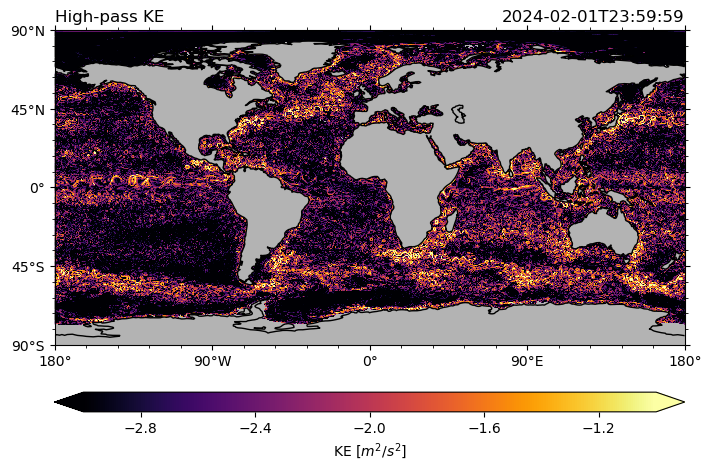

In [14]:
(0.5*(u_high**2 + v_high**2)).isel(time=-1).pyic.plot(cmap=cm.inferno, clim=(-3.0,-1.0), title_left="High-pass KE", logplot=True, cbar_str=f"KE [$m^2/s^2$]", fpath_tgrid=zarr_fpath_tgrid)

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 3.55 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'left': 'Low-pass KE', 'right': '2024-02-01T23:59:59'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff26418a110>])

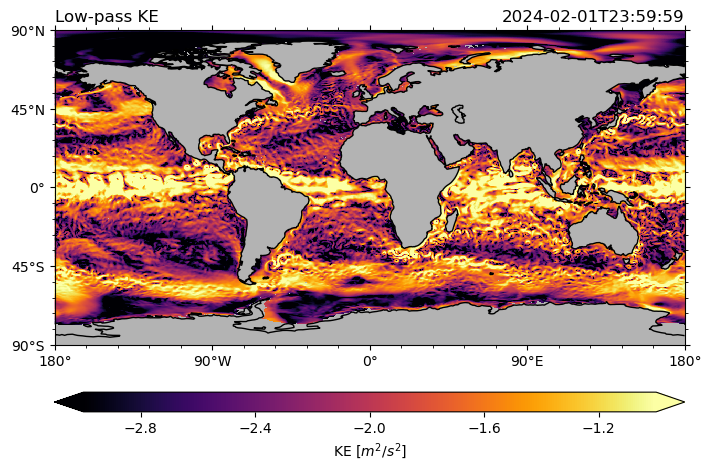

In [15]:
(0.5*(u_low**2 + v_low**2)).isel(time=-1).pyic.plot(cmap=cm.inferno, clim=(-3,-1), title_left="Low-pass KE", logplot=True, cbar_str=f"KE [$m^2/s^2$]", fpath_tgrid=zarr_fpath_tgrid)

### Filter Scalar Data, with 2nd Order Filter
N.B.: 2nd Order filter is necessary for many higher-order filtered statistics and when a sharp(er) filter cutoff is necessary. \
Note: 60 time-slices takes ~240 seconds (*120 seconds of which is overhead / GPU IO!*)

In [16]:
filter_order = 2

In [ ]:
t_slice = slice('2024-01-01', '2024-03-01')

## Low-pass filter
sst_full = ds_ocn.to.sel(time=t_slice)
sst_low = filter_uniform.filter_ICON(filter_order, filter_lengthscale, sst_full)

## High-pass filter
sst_high = (sst_full - sst_low)

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 3.38 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'left': 'High-pass SST', 'right': '2024-03-01T23:59:59'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff1d81654b0>])

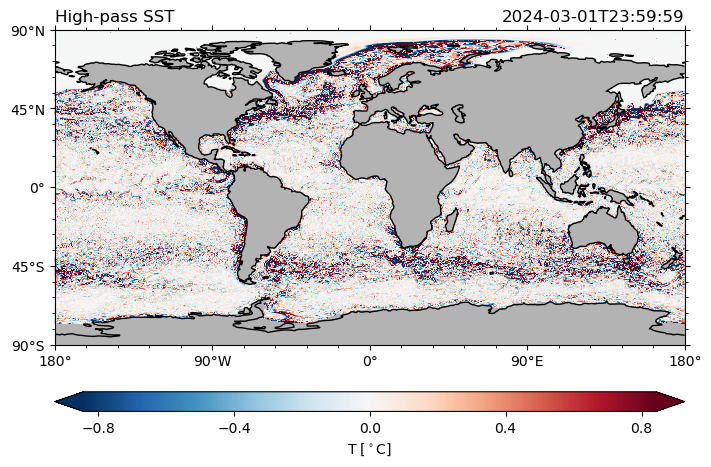

In [18]:
sst_high.isel(time=-1).pyic.plot(clim='robustsym', title_left="High-pass SST", cbar_str=f"T [$^\circ$C]", fpath_tgrid=zarr_fpath_tgrid)

# Example 2: Variable Length-Scale Filter ($\propto \mathcal{L}_\mathrm{Ro}$)

### Compute / Load & Define Filter

Construct a filter here defined by:
- $\Delta \propto \mathcal{L}_\mathrm{Ro}$, with a pre-specified minimum and maximum $\mathcal{L}_\mathrm{Ro}$
- Neumann BCs at edge of surface land-sea mask
- Both scalar & full vector-metric filters

N.B.: The filter length-scale is: $\Delta(x,y) \equiv$ `filter_scale` $\cdot \, \mathcal{L}_\mathrm{Ro, clipped}(x,y)$, \
where the clipped Rossby Radius, $\mathcal{L}_\mathrm{Ro, clipped} \equiv \mathrm{clip}(\mathcal{L}_\mathrm{Ro},$ `L_Ro_min`, `L_Ro_max` $)$ \
Therefore, the maximum & minimum filter length-scale is `filter_scale * L_Ro_max` & `filter_scale * L_Ro_min` (resp.)

In [19]:
filter_order    = 1   
L_Ro_max        = 20.0  # Maximum Rossby Radius (km)
L_Ro_min        = 5.0   # Minimum Rossby Radius (km)
filter_scale    = 20.0  # Filter scale, in units of L_Ro (i.e. how many Rossby radii to include in the filter)

In [ ]:
# Variable L_Ro Filter (takes ~8 minutes per filter)
if remake_filter or not os.path.exists(str(filter_dir / "filter_cache_2D_LRo_full_ocean.npz")):
    L_Ro = xr.open_dataarray('/home/b/b382615/data/RossbyRadius_ICON_native.nc')  # 
    mask = grid2d.cell_sea_land_mask
    full_ocean_mask = xr.where(mask < 0.0, 1.0, 0.0)  # 1.0 for entire ocean  
    
    # Filter for Scalar Fields
    filter_LRo = AMGXFilter()
    filter_LRo.prepare_ICON_filter(grid2d, ocean_mask=full_ocean_mask, full=False, L_Ro=L_Ro, L_Ro_min = L_Ro_min, L_Ro_max = L_Ro_max)
    filter_LRo.save_to_file(filter_dir / "filter_cache_2D_LRo_full_ocean")
    
    # Filter for Vector Fields ("full" = True)
    filter_vec_LRo = AMGXFilter()
    filter_vec_LRo.prepare_ICON_filter(grid2d, ocean_mask=full_ocean_mask, full=True, L_Ro=L_Ro, L_Ro_min = L_Ro_min, L_Ro_max = L_Ro_max)
    filter_vec_LRo.save_to_file(filter_dir / "filter_cache_full_2D_LRo_full_ocean")

else:
    filter_LRo = AMGXFilter.load_from_file(filter_dir / "filter_cache_2D_LRo_full_ocean.npz")
    filter_vec_LRo = AMGXFilter.load_from_file(filter_dir / "filter_cache_full_2D_LRo_full_ocean.npz")

### Filter Scalar Data
Note: 60 time-slices takes ~90 seconds (*70 seconds of which is overhead / GPU IO!*)

In [ ]:
t_slice = slice('2024-01-01', '2024-03-01')

## Low-pass filter
sst_full = ds_ocn.to.sel(time=t_slice)
sst_low = filter_LRo.filter_ICON(filter_order, filter_scale, sst_full)

## High-pass filter
sst_high = (sst_full - sst_low)

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 3.38 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'left': 'High-pass SST', 'right': '2024-03-01T23:59:59'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff18828d990>])

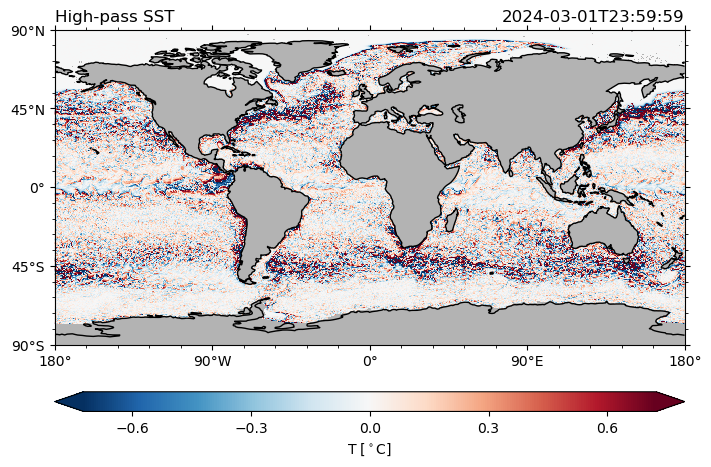

In [22]:
sst_high.isel(time=-1).pyic.plot(clim='robustsym', title_left="High-pass SST", cbar_str=f"T [$^\circ$C]", fpath_tgrid=zarr_fpath_tgrid)

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 3.38 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'left': 'Low-pass SST', 'right': '2024-03-01T23:59:59'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff13abc51e0>])

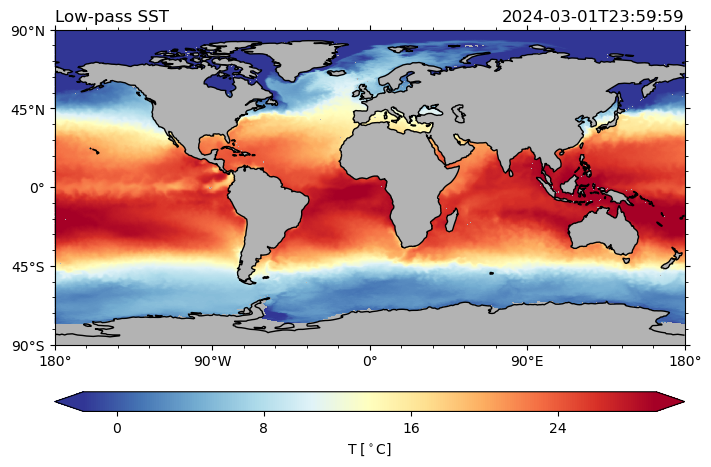

In [23]:
sst_low.isel(time=-1).pyic.plot(clim='robust', title_left="Low-pass SST", cbar_str=f"T [$^\circ$C]", fpath_tgrid=zarr_fpath_tgrid)

### Filter Vector Data
*It is important to filter vector data with the full vector-metric filter !* \
Note: 32 vector time-slices takes ~140 seconds

In [ ]:
t_slice = slice('2024-01-01', '2024-02-01')

## Low-pass filter
u_full = ds_ocn.u.sel(time=t_slice)
v_full = ds_ocn.v.sel(time=t_slice)
u_low, v_low = filter_vec_LRo.filter_ICON(filter_order, filter_scale, u_full, v_full)

## High-pass filter
u_high = (u_full - u_low)
v_high = (v_full - v_low)

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 3.55 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'left': 'High-pass KE', 'right': '2024-02-01T23:59:59'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff13a3b0a60>])

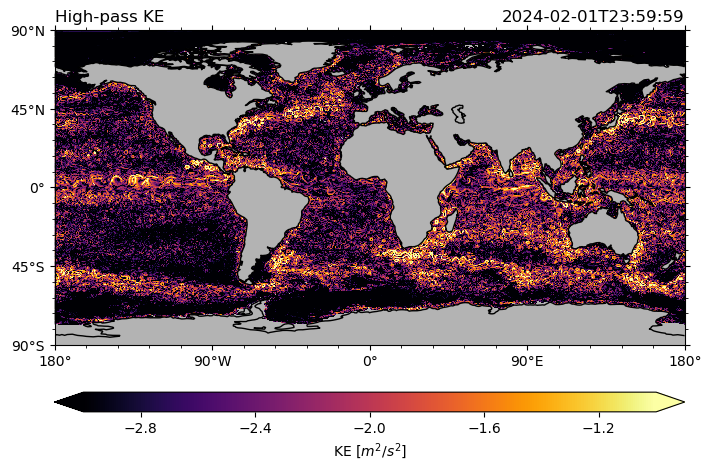

In [25]:
(0.5*(u_high**2 + v_high**2)).isel(time=-1).pyic.plot(cmap=cm.inferno, clim=(-3.0,-1.0), title_left="High-pass KE", logplot=True, cbar_str=f"KE [$m^2/s^2$]", fpath_tgrid=zarr_fpath_tgrid)

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 3.55 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'left': 'Low-pass KE', 'right': '2024-02-01T23:59:59'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff139fdb430>])

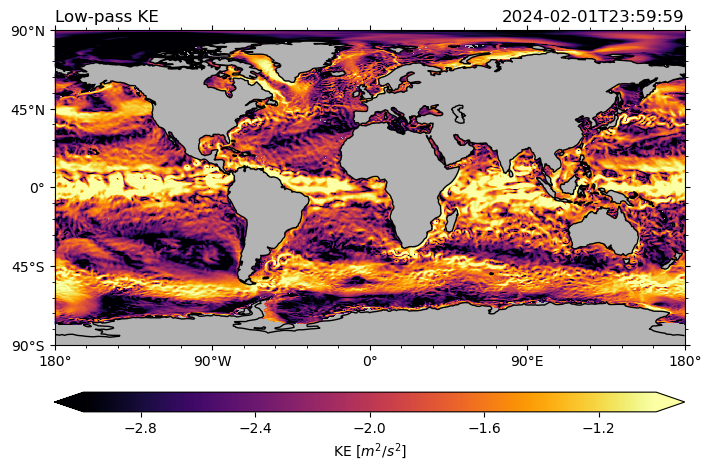

In [26]:
(0.5*(u_low**2 + v_low**2)).isel(time=-1).pyic.plot(cmap=cm.inferno, clim=(-3,-1), title_left="Low-pass KE", logplot=True, cbar_str=f"KE [$m^2/s^2$]", fpath_tgrid=zarr_fpath_tgrid)

# Example 3: Computing Spectra
Because the overhead setting up the filter on the GPU is so large, it is best to use the spectra wrapper (to parallelise remaining on the GPU). \
e.g. here, we filter a single time slice with 78 different filter length-scales. \
N.B.: It is not possible to implement this GPU-parallel spectra computation reusing the sparse matrices with AMGX; therefore, we need to use the `CuPyFilter` class which implements CG. 

In [8]:
# Set up Filter:
filter_uniform = CuPyFilter.load_from_file(filter_dir / "filter_cache_2D_const_full_ocean.npz")
filter_order = 1
band_width = 50 #km
filter_lengthscales = np.arange(100, 1000, band_width) #km

In [ ]:
## Low-pass spectra
sst_spectrum = filter_uniform.filter_ICON(filter_order, filter_lengthscales, ds_ocn.to.isel(time=10))
sst_spectrum['filter_scale'] = 1./sst_spectrum['k']

In [ ]:
# Note the new `filter_scale` dimension:
sst_spectrum

In [ ]:
## Calculate band-pass
sst_band_pass = sst_spectrum.shift(filter_scale=1) - sst_spectrum

/home/b/b382615/opt/anaconda3/envs/ICON_filter/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 113.58 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'left': 'Band-pass SST', 'right': '1991-01-11T23:59:59'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff15bb04d30>])

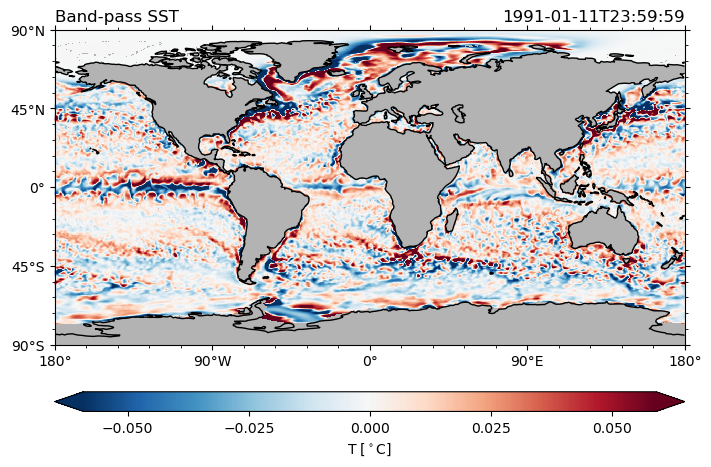

In [ ]:
sst_band_pass.isel(filter_scale=10).pyic.plot(clim='robustsym', title_left="Band-pass SST", cbar_str=f"T [$^\circ$C]", fpath_tgrid=zarr_fpath_tgrid)

# Example 4: Batch-Filtering
Due to memory constraints on the GPUs themselves, we need to submit large jobs in batches... \
For scalar filters, a batch size of ~40 is sufficient for the 80Gb A100 GPUs. \
For vector filters, a batch size of ~20 is good.

In [ ]:
t_slice = slice('2024-01-01', '2025-01-01')
sst_full = ds_ocn.to.sel(time=t_slice)

In [ ]:
n_batch = 40
n_time = sst_full.time.values.shape[0]

for i in range(0, n_time, n_batch):
    
    i_end = min(i + n_batch, n_time)
    
    da_low = filter_LRo.filter_ICON(2, filter_scale, sst_full.isel(time=slice(i, i_end)))   # Low-pass filter
    
    da_low.name = var_name
    da_low.time.attrs = {}
    
    da_low.to_zarr(str(zarr_store_low), region={'time': slice(i, i_end), 'ncells': slice(None)}, mode='r+')
    